In [1]:
!pip install tensorflow matplotlib seaborn


In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)


In [4]:
def build_baseline_cnn():
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(32,32,3)),
        layers.MaxPooling2D(),

        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D(),

        layers.Conv2D(128, (3,3), activation='relu', padding='same'),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])

    return model

baseline = build_baseline_cnn()
baseline.compile(optimizer=Adam(1e-3),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])
baseline.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,143,242 (4.36 MB)

 Trainable params: 1,143,242 (4.36 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
def self_attention_block(inputs):
    channels = inputs.shape[-1]

    q = layers.Conv2D(channels // 8, kernel_size=1, padding='same')(inputs)
    k = layers.Conv2D(channels // 8, kernel_size=1, padding='same')(inputs)
    v = layers.Conv2D(channels, kernel_size=1, padding='same')(inputs)

    q_flat = layers.Reshape((-1, channels // 8))(q)
    k_flat = layers.Reshape((-1, channels // 8))(k)
    v_flat = layers.Reshape((-1, channels))(v)

    att = layers.Lambda(lambda x: tf.matmul(x[0], x[1], transpose_b=True))([q_flat, k_flat])
    att = layers.Activation('softmax')(att)

    out = layers.Lambda(lambda x: tf.matmul(x[0], x[1]))([att, v_flat])

    out = layers.Reshape(inputs.shape[1:])(out)

    out = layers.Add()([out, inputs])

    return out


In [6]:
def build_attention_cnn():
    inputs = layers.Input(shape=(32,32,3))

    x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(inputs)
    x = self_attention_block(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = self_attention_block(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)
    x = self_attention_block(x)

    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(10, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    return model

att_cnn = build_attention_cnn()
att_cnn.compile(optimizer=Adam(1e-3),
                loss='categorical_crossentropy',
                metrics=['accuracy'])
att_cnn.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 32, 32,    │        896 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32, 4) │        132 │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32, 4) │        132 │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1024, 4)   │          0 │ conv2d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 1024, 4)   │          0 │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 1024,      │          0 │ reshape[0][0],    │
│                     │ 1024)             │            │ reshape_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │      1,056 │ conv2d_3[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 1024,      │          0 │ lambda[0][0]      │
│ (Activation)        │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 1024, 32)  │          0 │ conv2d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 1024, 32)  │          0 │ activation[0][0], │
│                     │                   │            │ reshape_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_3 (Reshape) │ (None, 32, 32,    │          0 │ lambda_1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 32, 32,    │          0 │ reshape_3[0][0],  │
│                     │ 32)               │            │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ add[0][0]         │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │     18,496 │ max_pooling2d_2[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 16, 8) │        520 │ conv2d_7[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 16, 16, 8) │        520 │ conv2d_7[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_4 (Reshape) │ (None, 256, 8)    │          0 │ conv2d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_5 (Reshape) │ (None, 256, 8)    │          0 │ conv2d_9[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, 256, 256)  │          0 │ reshape_4[0][0],

 Total params: 1,170,402 (4.46 MB)

 Trainable params: 1,170,402 (4.46 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
history_baseline = baseline.fit(
    x_train, y_train,
    epochs=15,
    batch_size=64,
    validation_split=0.2,
    verbose=1
)

history_self_attention = att_cnn.fit(
    x_train, y_train,
    epochs=15,
    batch_size=64,
    validation_split=0.2,
    verbose=1
)


Epoch 1/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.3686 - loss: 1.7370 - val_accuracy: 0.5705 - val_loss: 1.2016
Epoch 2/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6206 - loss: 1.0785 - val_accuracy: 0.6629 - val_loss: 0.9752
Epoch 3/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7017 - loss: 0.8597 - val_accuracy: 0.6880 - val_loss: 0.8962
Epoch 4/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7437 - loss: 0.7353 - val_accuracy: 0.7094 - val_loss: 0.8506
Epoch 5/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7836 - loss: 0.6245 - val_accuracy: 0.7308 - val_loss: 0.7970
Epoch 6/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8235 - loss: 0.5105 - val_accuracy: 0.7362 - val_loss: 0.8059
Epoch 7/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8591 - loss: 0.4115 - val_accuracy: 0.7362 - val_loss: 0.8326
Epoch 8/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8859 - loss: 0.3289 - val_accuracy: 0.

In [8]:
baseline_test = baseline.evaluate(x_test, y_test, verbose=0)
self_att_test = att_cnn.evaluate(x_test, y_test, verbose=0)

print("Baseline Test Accuracy:", baseline_test[1])
print("Self-Attention CNN Test Accuracy:", self_att_test[1])


Baseline Test Accuracy: 0.7146999835968018
Self-Attention CNN Test Accuracy: 0.724399983882904


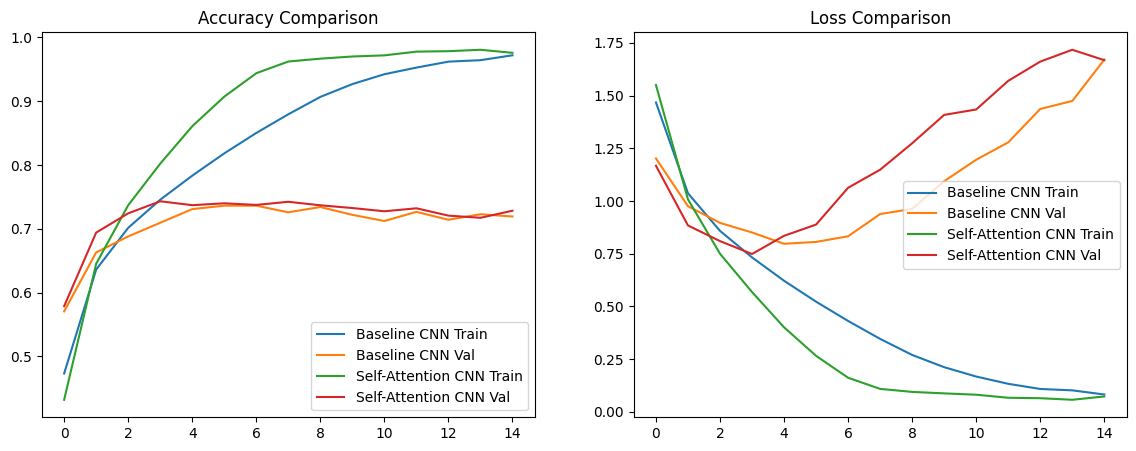

In [9]:
def plot_history(h1, h2, label1="Baseline", label2="Self-Attention CNN"):
    plt.figure(figsize=(14,5))
    plt.subplot(1,2,1)
    plt.plot(h1.history['accuracy'])
    plt.plot(h1.history['val_accuracy'])
    plt.plot(h2.history['accuracy'])
    plt.plot(h2.history['val_accuracy'])
    plt.title("Accuracy Comparison")
    plt.legend([f'{label1} Train', f'{label1} Val',
                f'{label2} Train', f'{label2} Val'])

    plt.subplot(1,2,2)
    plt.plot(h1.history['loss'])
    plt.plot(h1.history['val_loss'])
    plt.plot(h2.history['loss'])
    plt.plot(h2.history['val_loss'])
    plt.title("Loss Comparison")
    plt.legend([f'{label1} Train', f'{label1} Val',
                f'{label2} Train', f'{label2} Val'])

    plt.show()

plot_history(history_baseline, history_self_attention,
             label1="Baseline CNN",
             label2="Self-Attention CNN")
